<a href="https://colab.research.google.com/github/maximum4645/ComputerVision/blob/main/transfer_learning_by_4o_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)

def download_dataset():

    # Define a transform to normalize the data
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # Load the training and test datasets
    train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=4,
                                            shuffle=True, num_workers=2)

    test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,
                                            shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return [train_loader, test_loader, classes]

def visualize_images(data_loader, classes, num_show=4):

    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    for i in range(num_show):
        plt.subplot(1, num_show, i + 1)
        image = images[i] / 2 + 0.5 # Unnormalize
        image = image.numpy()
        plt.imshow(np.transpose(image, (1, 2, 0))) # (C, H, W) to (H, W, C)
        plt.axis('off')
        plt.title(classes[labels[i]])

def get_pretrained_model_1():
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)
    # Replace the last layer (fully connected layer) to give 10 output classes
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    return model

def get_pretrained_model_2():
    weights = models.MobileNet_V2_Weights.DEFAULT
    model = models.mobilenet_v2(weights=weights)
    # Replace the last layer (fully connected layer) to give 10 output classes
    model.classifier[1] = nn.Linear(model.last_channel, 10)
    return model

def evaluate_model(model, data_loader):
    all_predictions = []
    bool_predictions = []
    model.eval() # Set model to evaluation mode
    num_correct = 0
    num_total = 0
    with torch.no_grad(): # Disable gradient computation
        for batch_data in data_loader:
            images, labels = batch_data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)

            num_total += labels.size(0)
            num_correct += (predictions == labels).sum().item()

            for i in range(images.shape[0]):
                all_predictions.append((images[i], predictions[i].item(), labels[i].item()))
                bool_predictions.append(predictions[i].item() == labels[i].item())

    accuracy = 100 * num_correct / num_total
    print("Total :", num_total)
    print("Correct :", num_correct)
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return [accuracy, all_predictions, bool_predictions]

def train_model(model, criterion, optimizer, num_epochs, train_loader):
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        for i, batch_data in enumerate(train_loader, 0):
            inputs, labels = batch_data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the parameters

            running_loss += loss.item()
            if i % 2000 == 1999:    # Print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    return model

def imshow(img, ax=None, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.cpu().numpy()
    if ax is None:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        if title:
            ax.set_title(title)
        ax.axis('off')

Files already downloaded and verified
Files already downloaded and verified


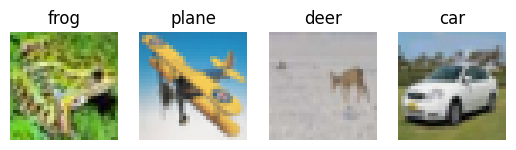

In [9]:
# Dataset
[train_loader, test_loader, classes] = download_dataset()

# Visualize some images
visualize_images(train_loader, classes)

In [10]:
# Pretrained model
model = get_pretrained_model_1()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Evaluate the model
[initial_accuracy, initial_all_predictions, initial_bool_predictions] = evaluate_model(model, test_loader)
print('Initial accuracy :', initial_accuracy)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5

# Train the model
initial_state = model.state_dict()
model = train_model(model, criterion, optimizer, num_epochs, train_loader)
final_state = model.state_dict()

# Evaluate the model again
[final_accuracy, final_all_predictions, final_bool_predictions] = evaluate_model(model, test_loader)
print('Final accuracy :', final_accuracy)

Total : 10000
Correct : 992
Accuracy of the model on the test images: 9.92%
Initial accuracy : 9.92
[1,  2000] loss: 2.675
[1,  4000] loss: 2.506
[1,  6000] loss: 2.425
[1,  8000] loss: 2.336
[1, 10000] loss: 2.321
[1, 12000] loss: 2.418
[2,  2000] loss: 2.324
[2,  4000] loss: 2.307
[2,  6000] loss: 2.236
[2,  8000] loss: 2.195
[2, 10000] loss: 2.161
[2, 12000] loss: 2.214
[3,  2000] loss: 2.133
[3,  4000] loss: 2.062
[3,  6000] loss: 2.014
[3,  8000] loss: 1.992
[3, 10000] loss: 2.057
[3, 12000] loss: 2.020
[4,  2000] loss: 1.970
[4,  4000] loss: 1.988
[4,  6000] loss: 1.998
[4,  8000] loss: 1.968
[4, 10000] loss: 1.935
[4, 12000] loss: 1.935
[5,  2000] loss: 1.949
[5,  4000] loss: 1.886
[5,  6000] loss: 1.905
[5,  8000] loss: 1.932
[5, 10000] loss: 1.898
[5, 12000] loss: 1.826
Finished Training
Total : 10000
Correct : 4317
Accuracy of the model on the test images: 43.17%
Final accuracy : 43.17


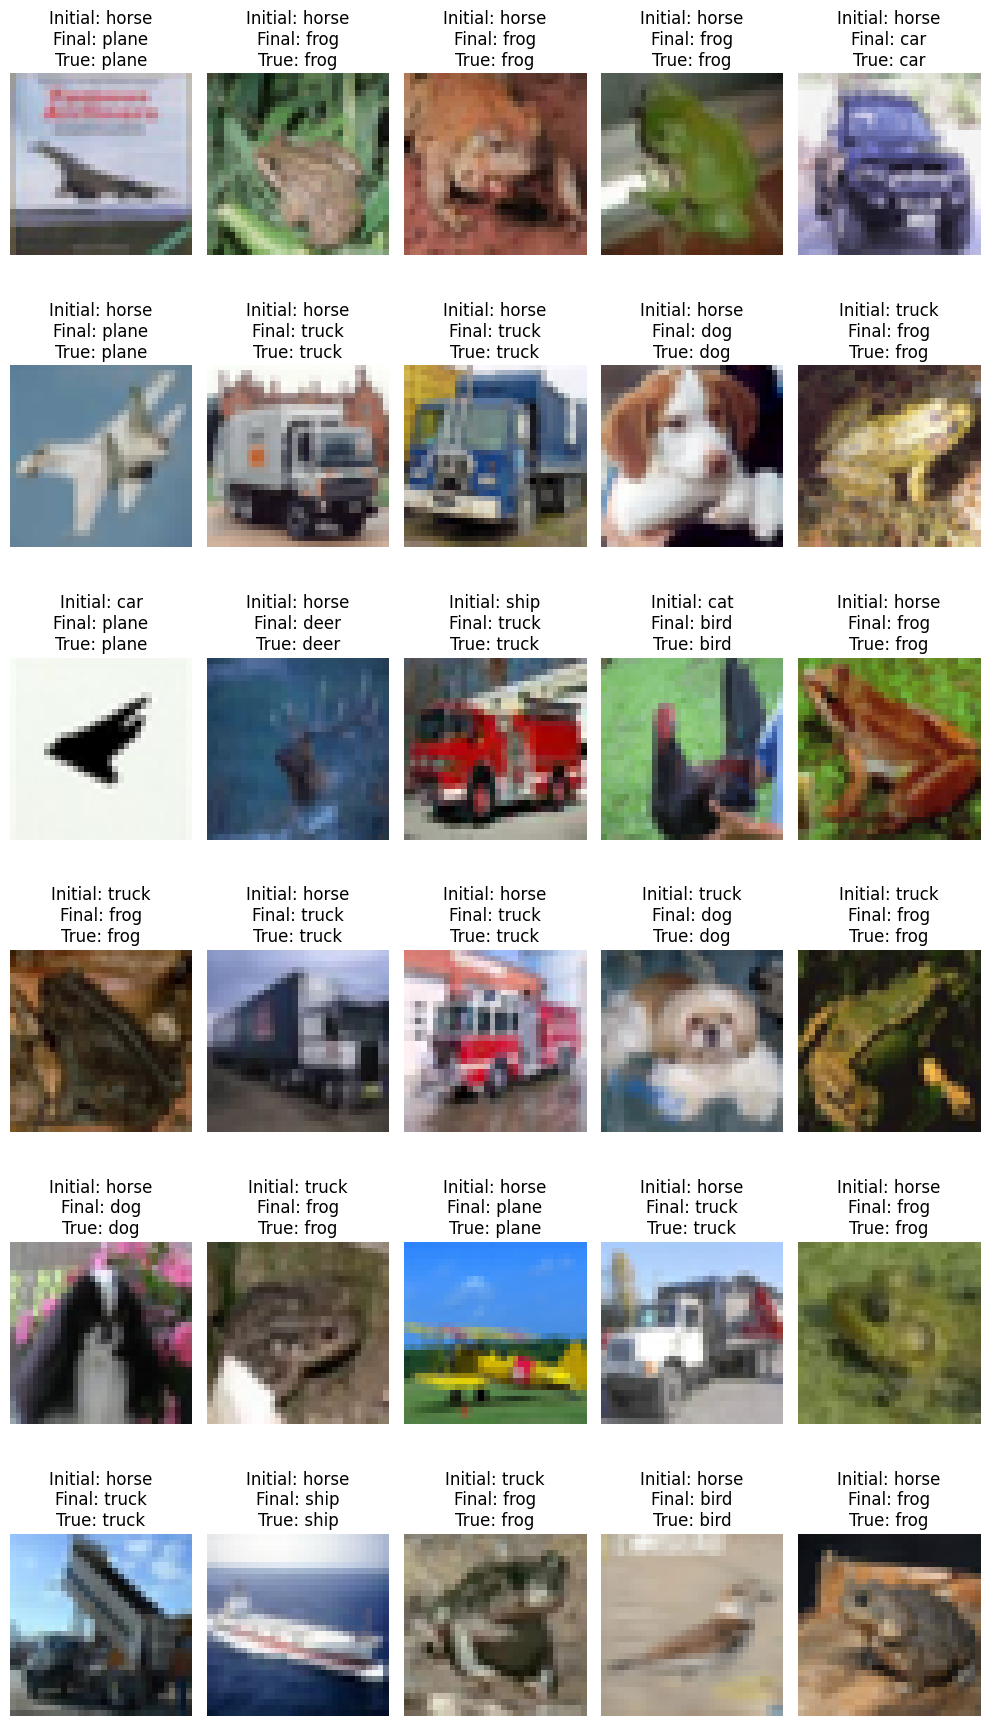

In [11]:
# Select the images that were initially wrong but correct after training
better_predictions = []
for i in range(len(initial_bool_predictions)):
    if (not initial_bool_predictions[i]) and (final_bool_predictions[i]):
        better_predictions.append((initial_all_predictions[i], final_all_predictions[i]))

# Number of images to show
num_images_to_show = min(30, len(better_predictions))
images_per_row = 5
num_rows = (num_images_to_show + images_per_row - 1) // images_per_row

# Create subplots
fig, axes = plt.subplots(num_rows, images_per_row, figsize=(10, 3 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Visualize the images
for i in range(num_images_to_show):
    initial_pred, final_pred = better_predictions[i]
    image, initial_label, true_label = initial_pred
    _, final_label, _ = final_pred
    imshow(image, ax=axes[i], title=f'Initial: {classes[initial_label]}\nFinal: {classes[final_label]}\nTrue: {classes[true_label]}')

# Hide any unused subplots
for j in range(num_images_to_show, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()